In [11]:
#purpose is to take HST images and identify extended sources (HH objects in our case)

#just to check python version - should be 3.7.4
from platform import python_version
print(python_version())

#importing astro libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

#importing general tools
import glob
import itertools
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

%matplotlib inline

3.8.13


In [12]:
# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names

# In[27]:

#setting up a new fits file to be saved and viewed in DS9
#primarily to save the image we reprojected, but can also be used to save the convolved images
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])
    
    #saving the file
    if name.find('FIT') == -1: #needed if file end incorrect
        new_filename = name.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
    else:
        name_fixfit = name[:-3] + 'fits'
        new_filename = name_fixfit.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
        
    return (save_path+new_filename)

# Gather some data, convert units!

In [13]:
# path = '../../Montage_results/n2071_headercut/*drz.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
# im_names_n2071 = sorted(im_name_finder(path, 'fit')) #im_finder is basically glob.glob
# im_names_n2071 = [i.replace('\\', '/') for i in im_names_n2071]
im_names_n2071 = ['../scaling_for_motions/160_epoch1_scaled.fits', '../scaling_for_motions/160_epoch2_synth_scaled.fits']

print(im_names_n2071)

# path = '../../Montage_results/n2071_headercut/*drz.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
# im_names_n2071 = sorted(im_name_finder(path, 'fit')) #im_finder is basically glob.glob
# im_names_n2071 = [i.replace('\\', '/') for i in im_names_n2071]
# print(im_names_n2071)

hdu_list = [fits.open(i) for i in im_names_n2071]

#initializing some lists to be used
hdu_pix_list = []
hdu_pixtorad_list = []
# hdu_fnu_list = []
hdu_lam_list = []
# hdu_flam_list = []
# hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []

count = 0
for hdu_data in hdu_list:   
    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    hdu_data_list.append(hdu_data[0].data) # * hdu_list[0].header['PHOTFLAM'] * hdu_list[0].header['PHOTBW'])
    hdu_header_list.append(hdu_data[0].header)
    
    count+=1

['../scaling_for_motions/160_epoch1_scaled.fits', '../scaling_for_motions/160_epoch2_synth_scaled.fits']


[]

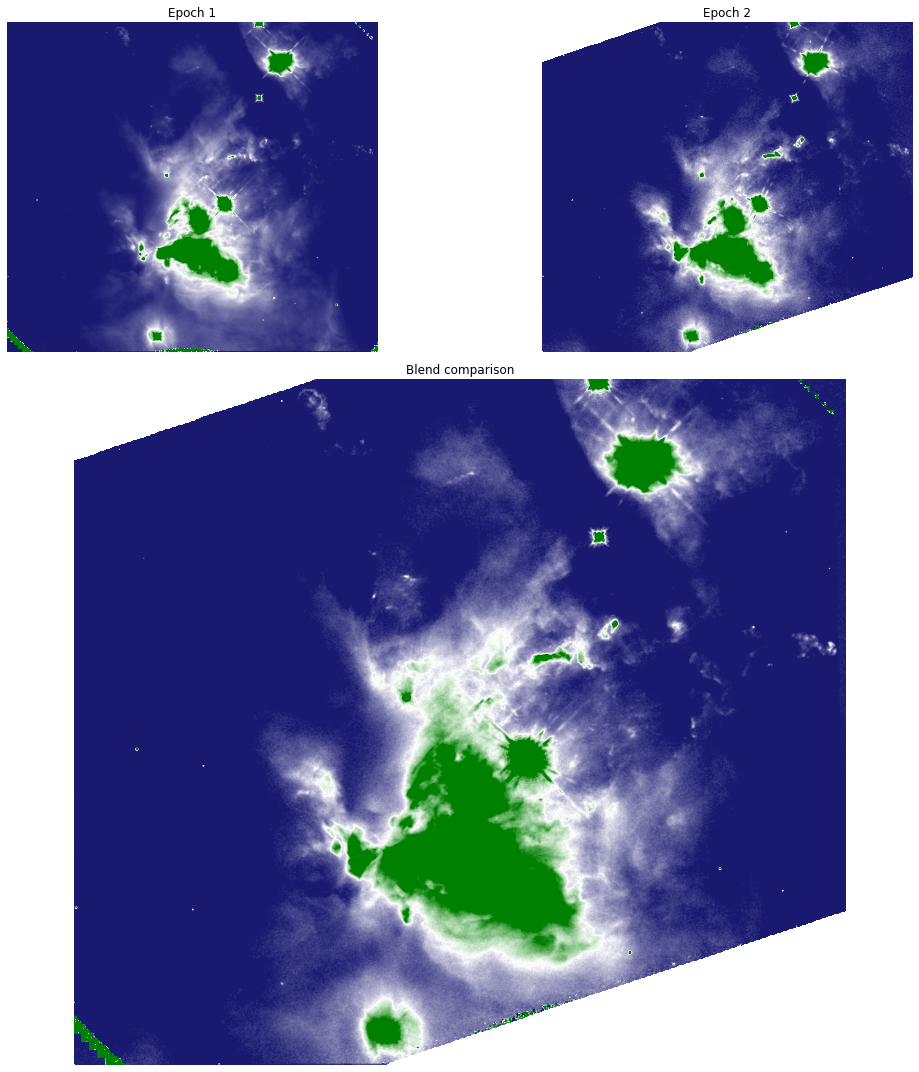

In [14]:
# https://scikit-image.org/docs/dev/auto_examples/applications/plot_image_comparison.html#sphx-glr-auto-examples-applications-plot-image-comparison-py
fig = plt.figure(figsize=(15,15))

from matplotlib.gridspec import GridSpec
gs = GridSpec(3, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1:, :])

ax0.imshow(hdu_data_list[0], cmap=cmap, vmin=0, vmax=0.00025)
ax0.set_title('Epoch 1')
ax1.imshow(hdu_data_list[1], cmap=cmap, vmin=0, vmax=0.0001)
ax1.set_title('Epoch 2')

from skimage.util import compare_images
blend_rotated = compare_images(hdu_data_list[0], hdu_data_list[1], method='blend')
ax2.imshow(blend_rotated, cmap=cmap, vmin=0, vmax=0.0001)
ax2.set_title('Blend comparison')
for a in (ax0, ax1, ax2):
    a.axis('off')
plt.tight_layout()
plt.plot()

# Next, try to identify some HH objects...
This is tricky. We'll need photutils, segmentation maps, a cutout of the image, maybe smoothing the image by convolution...

In [15]:
#installing any needed packages if you want to do photometry and segmentation (we do!)
# !conda install --yes --prefix {sys.prefix} -c conda-forge photutils

In [16]:
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import detect_threshold
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.stats import gaussian_fwhm_to_sigma
from photutils.segmentation import detect_sources
from photutils.segmentation import deblend_sources
from astropy.visualization import simple_norm

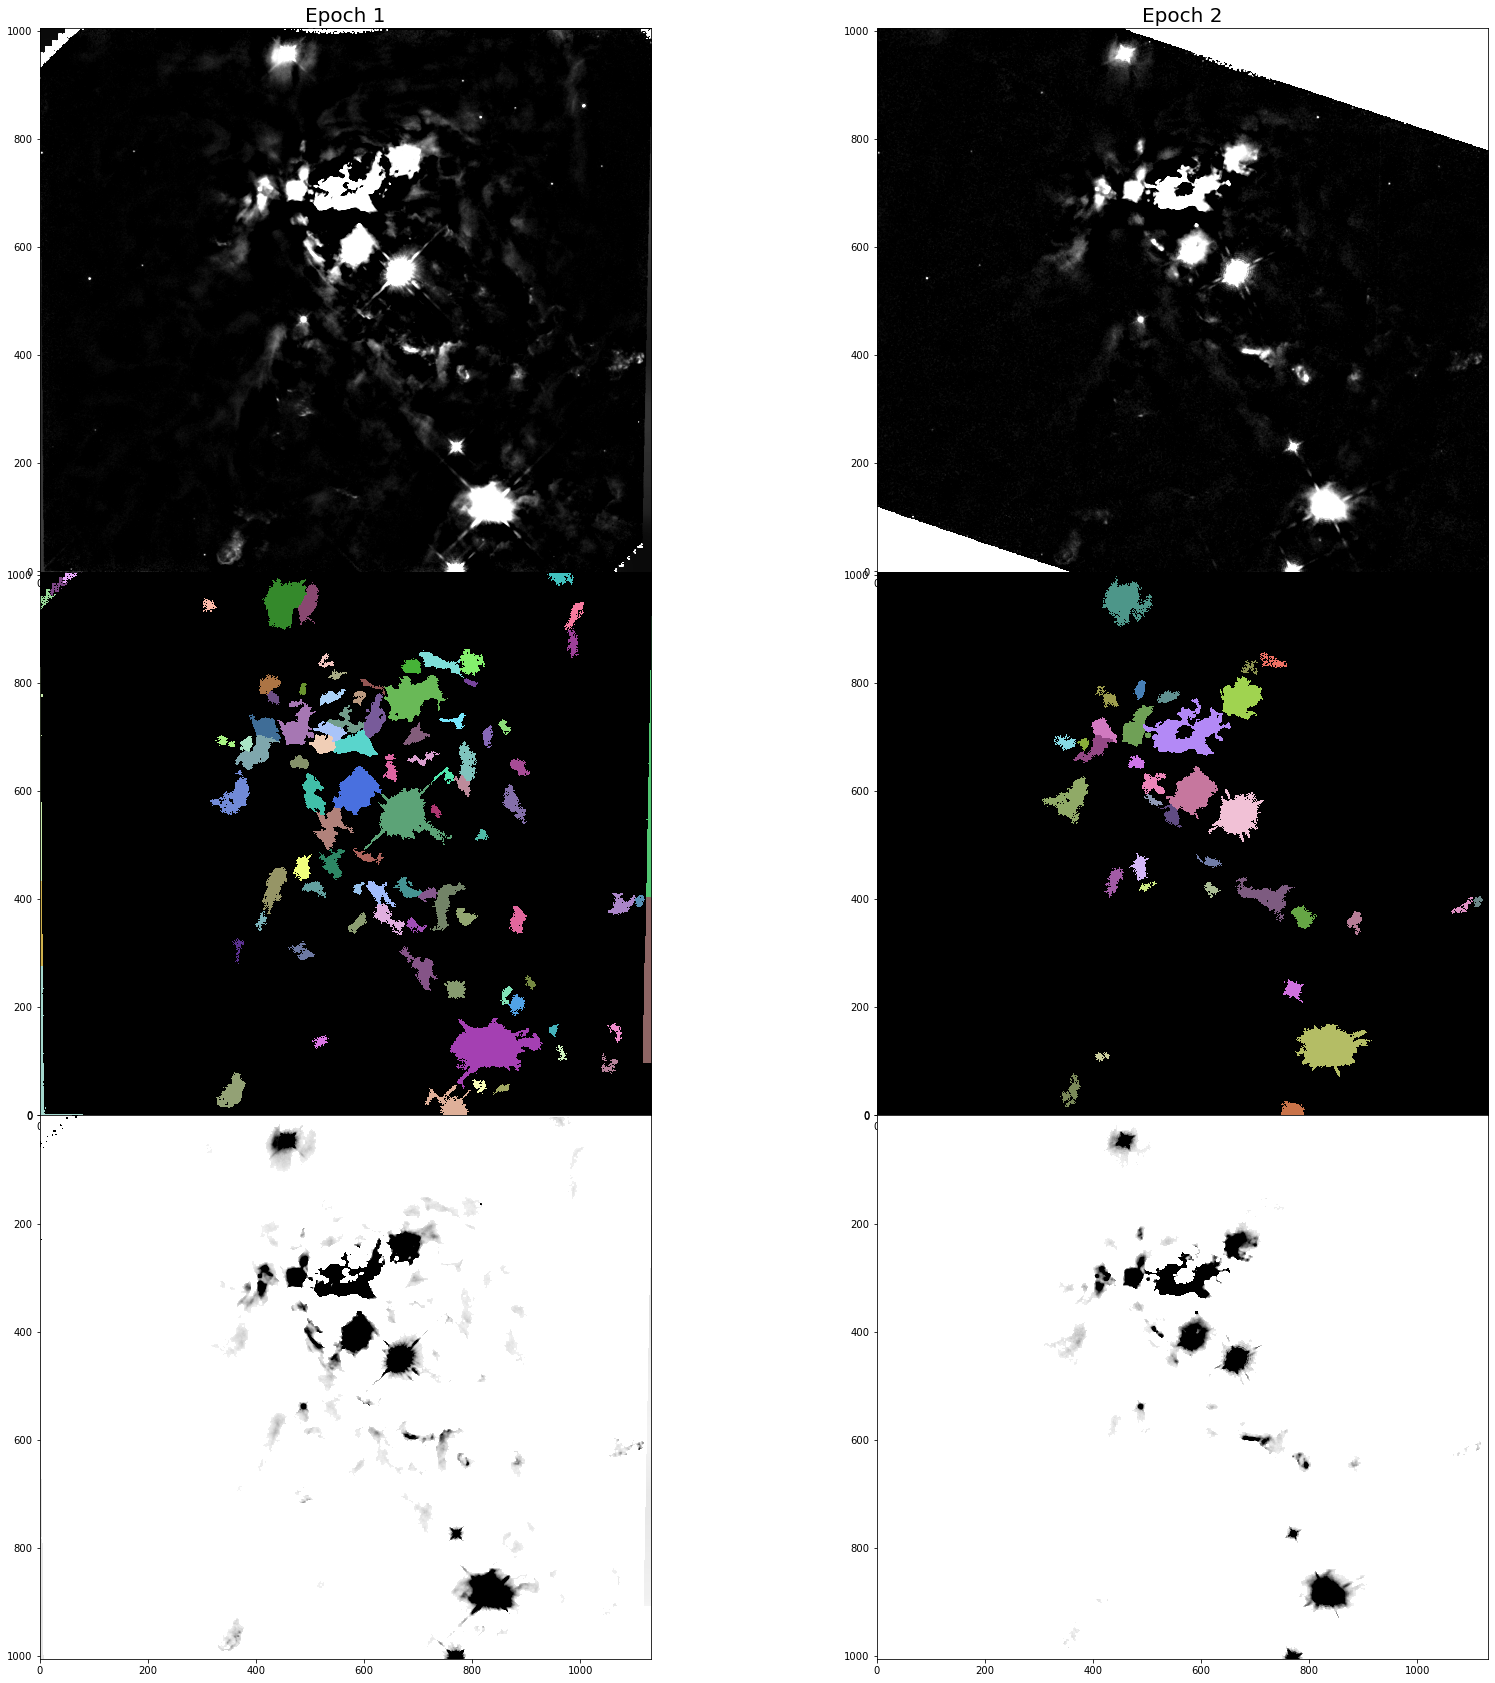

In [17]:
#this set of cells shows how to apply our procedure to an entire large mosaic image
#first step is background subtraction, thresholding
#I've found better to use no background subtracting, but the option is there if you like

#please see https://photutils.readthedocs.io/en/stable/segmentation.html for references and documentation
#the idea is to use the photutils package and/or segmentation maps to distinguish a bright source from background or noise


bkg_estimator = MedianBackground()
bkg_list = []
data_bkg_subtracted = []
threshold_list = []
nsig_list = [2, 1] #IMPORTANT, should change this...

for i in range(len(hdu_data_list)):
    bkg = Background2D(hdu_data_list[i], (25, 25), filter_size=(3, 3), bkg_estimator=bkg_estimator)
    bkg_list.append(bkg)
#     threshold_list.append(2. * bkg.background_rms )  # above the background
    threshold_list = detect_threshold(hdu_data_list[i], nsigma=nsig_list[i])
    data_bkg_subtracted.append( hdu_data_list[i] - bkg.background ) # subtract the background
    
    
#next we apply segmentation maps
npixels_list = [200, 200]
segm_deblend_list = []

for i in range(len(data_bkg_subtracted)):
    data = data_bkg_subtracted[i]
    threshold = threshold_list[i]
    npixels = npixels_list[i]
    segm = detect_sources(data, threshold, npixels=npixels)
    segm_deblend_list.append( deblend_sources(data, segm, npixels=npixels, nlevels=64, contrast=0.0001, progress_bar=False) )
    

#finally we plot the image, the segments, and also show you can automatically produce naive apertures
fig, ax = plt.subplots(3, 2, figsize=(30,30))
ax[0,0].set_title('Epoch 1', fontsize=20)
ax[0,1].set_title('Epoch 2', fontsize=20)

for i in range(len(hdu_data_list)):
    #plotting the thresholded data
    norm = simple_norm(data_bkg_subtracted[i], 'sqrt')
    ax[0,i].imshow(data_bkg_subtracted[i], origin='lower', cmap='Greys_r', vmin=0, vmax=0.0001)
    
    #plotting the associated segmentation map
    cmap = segm_deblend_list[i].make_cmap(seed=123)
    ax[1,i].imshow(segm_deblend_list[i], origin='lower', cmap=cmap, interpolation='nearest')
    
    
#looping through segments
for i in range(len(hdu_data_list)):
    for j in segm_deblend_list[i].labels:
        segm_nparr = np.array(segm_deblend_list[i])  #this is the list of segments 
        data_masked = np.ma.masked_array(data_bkg_subtracted[i], mask=segm_nparr) #masking the data using segm_nparr
        mask=np.ma.getmask(data_masked) #we need to invert the mask, so we grab it
        data_masked = np.ma.masked_array(data_bkg_subtracted[i], mask=~mask) #then we invert it
        im = ax[2,i].imshow(np.flip(data_masked, axis=0), vmin=0, vmax=0.0001, cmap='Greys')#, cmap=cmap_list[i])

        
for a in ax:
    for b in a:
    #     a.set_xticklabels([])
    #     a.set_yticklabels([])
        b.set_aspect('equal')
fig.subplots_adjust(wspace=0, hspace=0)

The problem with the above method is that it likely requires the exact same segments

Instead, we can maybe try this out on the difference image

# Segmenting the Difference Image

In [18]:
#segmented difference image...

#loading image, etc...
# path = '../../Montage_results/n2071_headercut/*drz.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
# im_names_n2071 = sorted(im_name_finder(path, 'fit')) #im_finder is basically glob.glob
# im_names_n2071 = [i.replace('\\', '/') for i in im_names_n2071]
im_names_n2071 = ['../scaling_for_motions/f160_diff_epoch2_1.fits']

print(im_names_n2071)

# path = '../../Montage_results/n2071_headercut/*drz.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
# im_names_n2071 = sorted(im_name_finder(path, 'fit')) #im_finder is basically glob.glob
# im_names_n2071 = [i.replace('\\', '/') for i in im_names_n2071]
# print(im_names_n2071)

hdu_list = [fits.open(i) for i in im_names_n2071]

#initializing some lists to be used
hdu_pix_list = []
hdu_pixtorad_list = []
# hdu_fnu_list = []
hdu_lam_list = []
# hdu_flam_list = []
# hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []

count = 0
for hdu_data in hdu_list:   
    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    hdu_data_list.append(hdu_data[0].data) # * hdu_list[0].header['PHOTFLAM'] * hdu_list[0].header['PHOTBW'])
    hdu_header_list.append(hdu_data[0].header)
    
    count+=1

['../scaling_for_motions/f160_diff_epoch2_1.fits']


In [19]:
#plot setup
#color map I was using from before for diff image
import matplotlib.colors #to setup a new color map that is friendly to colorblindness, can also see https://www.color-blindness.com/coblis-color-blindness-simulator/
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["midnightblue","white","green"])

from astropy import units as u
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.visualization.stretch import SinhStretch, AsinhStretch, LogStretch
from matplotlib.ticker import LogFormatter, LogLocator, FixedLocator, FixedFormatter

interval = ZScaleInterval()
data_interval = interval.get_limits(hdu_data_list[0])
ds9_min = -8.41819e-05
ds9_max = 8.47856e-05 
# norm = ImageNormalize(stretch=AsinhStretch(), vmin=data_interval[0], vmax=data_interval[1])
norm = ImageNormalize(stretch=AsinhStretch(), vmin=ds9_min, vmax=ds9_max)

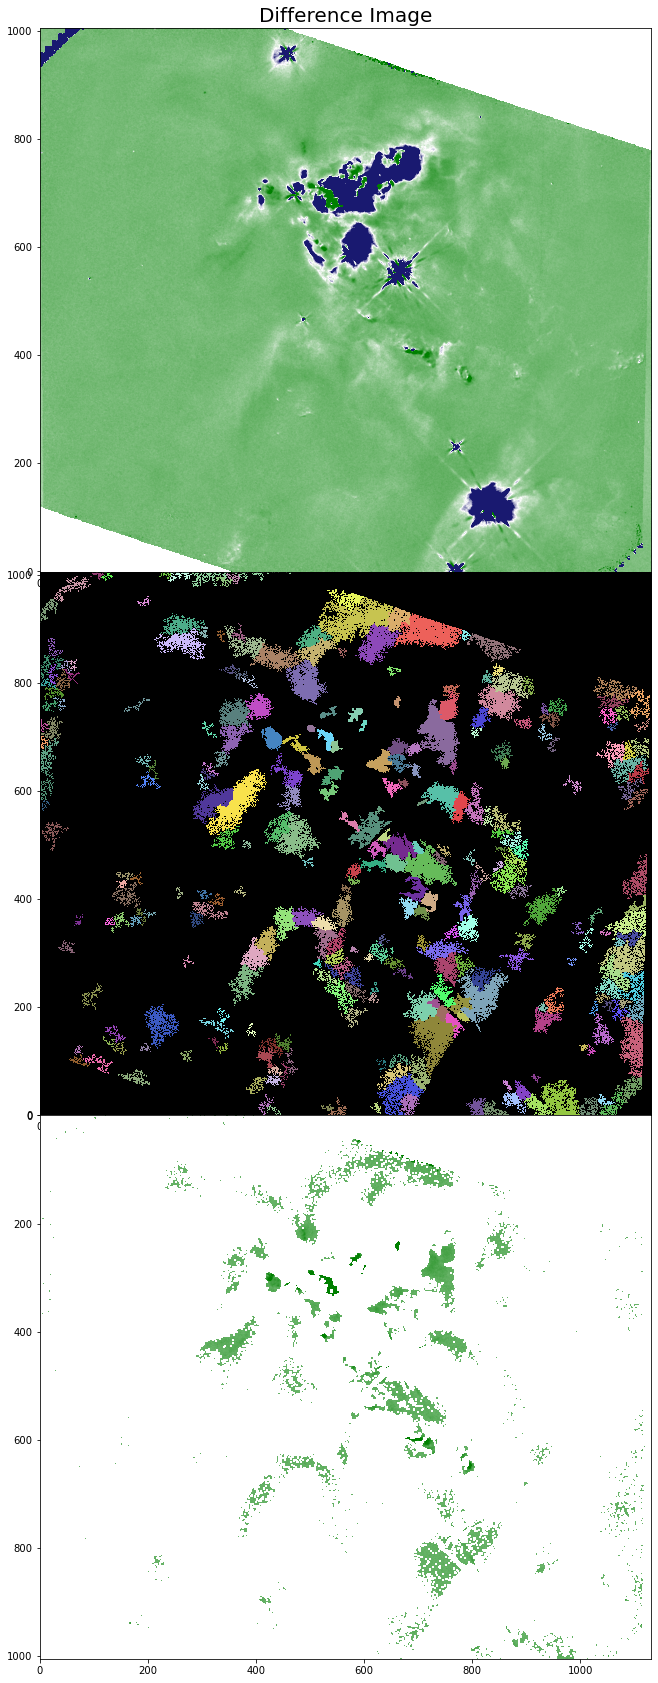

In [20]:
60#this set of cells shows how to apply our procedure to an entire large mosaic image
#first step is background subtraction, thresholding
#I've found better to use no background subtracting, but the option is there if you like

#please see https://photutils.readthedocs.io/en/stable/segmentation.html for references and documentation
#the idea is to use the photutils package and/or segmentation maps to distinguish a bright source from background or noise


bkg_estimator = MedianBackground()
bkg_list = []
data_bkg_subtracted = []
threshold_list = []
nsig_list = [0.5] #IMPORTANT, should change this...

for i in range(len(hdu_data_list)):
    bkg = Background2D(hdu_data_list[i], (50, 50), filter_size=(3,3), bkg_estimator=bkg_estimator)
    bkg_list.append(bkg)
#     threshold_list.append(2. * bkg.background_rms )  # above the background
    threshold_list = detect_threshold(hdu_data_list[i]  - bkg.background, nsigma=nsig_list[i])
    data_bkg_subtracted.append( hdu_data_list[i] - bkg.background ) # subtract the background
    
    
#next we apply segmentation maps
npixels_list = [100]
segm_deblend_list = []

for i in range(len(data_bkg_subtracted)):
    data = data_bkg_subtracted[i]
    threshold = threshold_list[i]
    npixels = npixels_list[i]
    segm = detect_sources(data, threshold, npixels=npixels)
    segm_deblend_list.append( deblend_sources(data, segm, npixels=npixels, 
                                              nlevels=32, contrast=0.0001, progress_bar=False) )
    

#finally we plot the image, the segments, and also show you can automatically produce naive apertures
fig, ax = plt.subplots(3, 1, figsize=(30,30))
ax[0].set_title('Difference Image', fontsize=20)

for i in range(len(hdu_data_list)):
    #plotting the thresholded data
    ax[0].imshow(data_bkg_subtracted[i], origin='lower', cmap=cmap, norm=norm)
    
    #plotting the associated segmentation map
    cmap_segm = segm_deblend_list[i].make_cmap(seed=123)
    ax[1].imshow(segm_deblend_list[i], origin='lower', cmap=cmap_segm, interpolation='nearest')
    
    
#looping through segments
for i in range(len(hdu_data_list)):
    for j in segm_deblend_list[i].labels:
        segm_nparr = np.array(segm_deblend_list[i])  #this is the list of segments 
        data_masked = np.ma.masked_array(data_bkg_subtracted[i], mask=segm_nparr) #masking the data using segm_nparr
        mask=np.ma.getmask(data_masked) #we need to invert the mask, so we grab it
        data_masked = np.ma.masked_array(data_bkg_subtracted[i], mask=~mask) #then we invert it
        im = ax[2].imshow(np.nan_to_num(np.flip(data_masked, axis=0)), cmap=cmap, norm=norm)

fig.subplots_adjust(wspace=0, hspace=0)

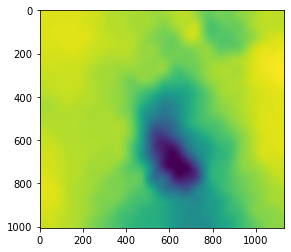

In [21]:
plt.imshow(bkg.background)

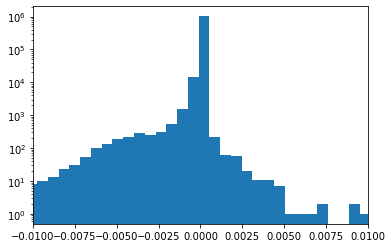

In [22]:
hist_data = plt.hist([x for x in (hdu_data_list[i] - bkg.background).ravel() if np.isnan(x) == False], bins=1000, log=True)
plt.xlim(-0.01, 0.01)
plt.show()

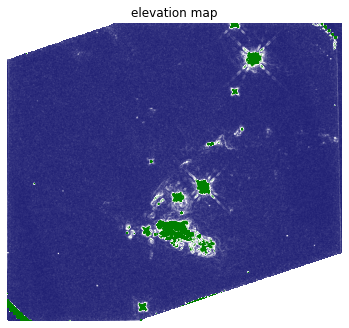

(-0.5, 1130.5, -0.5, 1005.5)

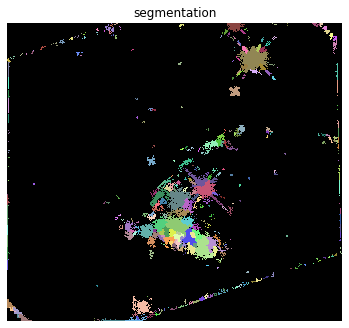

In [23]:
#based on https://en.wikipedia.org/wiki/Sobel_operator#MATLAB_implementation
# https://scikit-image.org/docs/dev/auto_examples/applications/plot_coins_segmentation.html#sphx-glr-auto-examples-applications-plot-coins-segmentation-py
from skimage.filters import sobel, scharr

#scaling
ds9_min = -8.41819e-05
ds9_max = 8.47856e-05 
data_scaled = np.log10((hdu_data_list[0] + 1.))
bkg = Background2D(data_scaled, (50, 50), filter_size=(3,3), bkg_estimator=bkg_estimator)

#edge detection filter
elevation_map = sobel(data_scaled - bkg.background)
# elevation_map = scharr(hdu_data_list[0])
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(elevation_map, cmap=cmap, vmin=0, vmax=ds9_max/3)
ax.set_title('elevation map')
ax.axis('off')
plt.show()

#thresholding and segmenting
detect_threshold(elevation_map, nsigma=0.5)
segm_grad = detect_sources(elevation_map, threshold, npixels=30)
segm_grad_deblend = ( deblend_sources(elevation_map, segm_grad, npixels=30, nlevels=32, contrast=0, progress_bar=False) )

#plotting segment map
fig, ax = plt.subplots(figsize=(6, 6))
cmap_segm = segm_grad_deblend.make_cmap(seed=123)
ax.imshow(np.flip(segm_grad_deblend, axis=0), origin='lower', cmap=cmap_segm, interpolation='nearest')
ax.set_title('segmentation')
ax.axis('off')

# attempting a sobel gradient plot converted to speed...

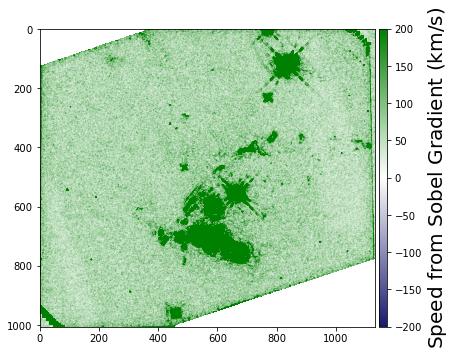

In [24]:
n2071_dist = 1.234e16  #400 pc to km
pix_size = 0.12825 #for hst
time = 3.471e+8 #10 yrs to secs

data_scaled = np.arcsinh(hdu_data_list[0]) / 1e-6
bkg = Background2D(data_scaled, (50, 50), filter_size=(3,3), bkg_estimator=bkg_estimator)
elevation_map = sobel(data_scaled)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(elevation_map*pix_size* n2071_dist/206265 / time, vmin=-200, vmax=200, cmap=cmap)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax) 
# cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm Speed~from~Sobel~Gradient~(km/s)$', size=20)
plt.show()

# take each segmentation object and get their respective bboxes (or just use my original regions list) 
... there is a convenient function for zoom-ins called "make_cutout" for a segment object

[  46   48   32   70   38   57   66   41  142   37   52   85   32   73
   46   46   64   64   37   46   61   68  116  108  128   67   32   34
  131   35   40   44   32   32   66   34  100   69   89  966   35   30
   43   45   30   48   51   32   38   64   68   31   72  131   74   43
   62   54   38   40   42  527  572   30   34   75   45   41  117   45
  145   30   53   31   94   45   59   35   35   68   36   32   48   85
   89  240  135   49   59   32   66   36   53   37   42   81   43   73
  139   55   37   62   37   38   32   99  259   56   58   38   41   42
   32   35   41   41   37   34   38   43   47   98   82  120   49   34
   41   32   57   34   52   53   31   36  329   51   70 1061  167  225
   93  177  177  176  167  343  273  176  107   97   69   51  121   80
   83  176  237  294  332 5042   79   97  336  389  199  103  343  100
   90   81  118   89   68  109   68   64  106   90   73  403  255  111
   80  153   91  316  306  213  838  138  130  238   83  110  205  105
   97 

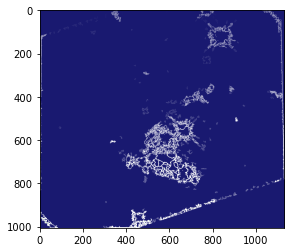

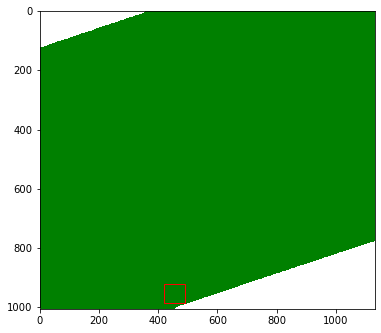

In [25]:
plt.imshow(segm_grad_deblend.outline_segments(), cmap=cmap)

print(segm_grad_deblend.areas)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(elevation_map, cmap=cmap, vmin=0, vmax=ds9_max/3)
segm_grad_deblend.bbox[-15].plot(axes=ax, color='red')
# hdu_data_list[0][segm_grad_deblend.bbox[0]]

In [69]:
#make slices or bbox out of the segm_grad_deblend, then that can be applied to the epoch 1 and epoch 2 images 
#and the rest of the code becomes the same after that!

#trying this with photutils and/or cutout2d
# https://docs.astropy.org/en/stable/nddata/utils.html#cutout-images
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord, FK5

#original files of interest
path = '../scaling_for_motions/160_epoch*.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
im_names_n2071 = sorted(im_name_finder(path, 'fit')) #im_finder is basically glob.glob
im_names_n2071 = [i.replace('\\', '/') for i in im_names_n2071]
print(im_names_n2071)
im_names_n2071 = [im_names_n2071[0], im_names_n2071[2]]
print(im_names_n2071)
hdu_list = [fits.open(i) for i in im_names_n2071]

#reading in data for general use  and header for wcs
hdu_epochdata_list = []
hdu_epochheader_list = []
count = 0
for hdu_data in hdu_list:   
    
    #needed because the second image in this list is negative...
    if count == 1:
        sign = -1
    else:
        sign = 1
    
    hdu_epochdata_list.append(sign * hdu_data[0].data)
    hdu_epochheader_list.append(hdu_data[0].header)
    count+=1

    
#next step is for one image, loop through all regions and make a cutout list
#typical region or aperture contents = ra, dec, width, height, rotation
#https://photutils.readthedocs.io/en/stable/api/photutils.aperture.BoundingBox.html#photutils.aperture.BoundingBox.to_aperture
 # numpy order: (y, x)
# shape = segm_grad_deblend.bbox[0].shape
# print(center, shape)
segm_area_filtered = [i for i in segm_grad_deblend.segments if i.area < 5000] #area filter
center_list = [i.bbox.center for i in segm_area_filtered] #needed for later...
shape_list = [i.bbox.shape for i in segm_area_filtered] #needed for later...
aper_list = [i.bbox.to_aperture() for i in segm_area_filtered] #to aperture
aper_mask_list = [i.to_mask() for i in aper_list] #for masking the data

#computing regions
epoch1_reg = [i.cutout(np.flip(hdu_epochdata_list[0], axis=0)) for i in aper_mask_list]
epoch2_reg = [i.cutout(np.flip(hdu_epochdata_list[1], axis=0)) for i in aper_mask_list]
#         plt.savefig(im_type[count]+str(reg_num)+'.png')

['../scaling_for_motions/160_epoch1.fits', '../scaling_for_motions/160_epoch1_scaled.fits', '../scaling_for_motions/160_epoch2_synth.fits', '../scaling_for_motions/160_epoch2_synth_scaled.fits']
['../scaling_for_motions/160_epoch1.fits', '../scaling_for_motions/160_epoch2_synth.fits']


# find the cross-corr of those boxes with each other + centroiding

[8, 9]
[9.37604225] [8.07990991]


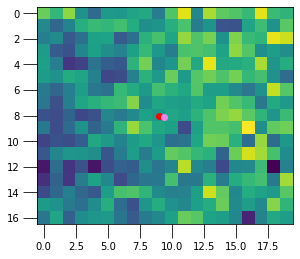

[8, 9]
[9.44530946] [7.99402414]


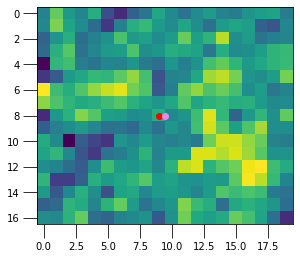

In [70]:
import scipy.signal
def cross_image(im1, im2):
   # the type cast into 'float' is to avoid overflows
   # get rid of the averages, otherwise the results are not good
    im1 -= np.mean(im1)
    im2 -= np.mean(im2)

   # calculate the correlation image; note the flipping of onw of the images
    return scipy.signal.convolve2d(im1, im2)

#attempting centroids...
epoch1_example = epoch1_reg[-14]
epoch2_example = epoch2_reg[-14]

corr_img = cross_image(epoch1_example, epoch1_example)
# plt.imshow(corr_img)
plt.imshow(epoch1_example, vmin=np.min(epoch1_example), vmax=np.max(epoch1_example))

self_brightest = [int(brightest/2) for brightest in np.unravel_index(np.argmax(corr_img), corr_img.shape)]
print(self_brightest)
plt.scatter(self_brightest[1], self_brightest[0], color='red')

from photutils.centroids import centroid_com, centroid_quadratic
from photutils.centroids import centroid_1dg, centroid_2dg
from photutils.centroids import centroid_sources
x, y = centroid_sources(corr_img, self_brightest[0], self_brightest[1], 
                        box_size=[corr_img.shape[0], corr_img.shape[1]], centroid_func=centroid_quadratic)
print(x/2,y/2)
plt.scatter(x/2, y/2, color='violet')
plt.show()


#Then do the cross-corr again but between the two images to find where the bright spot traveled to...
corr_img = cross_image(epoch1_example, epoch2_example)
# plt.imshow(corr_img)
plt.imshow(epoch2_example, vmin=np.min(epoch2_example), vmax=np.max(epoch2_example))
moved_brightest = [int(brightest/2) for brightest in np.unravel_index(np.argmax(corr_img), corr_img.shape)]
print(moved_brightest)
plt.scatter(moved_brightest[1], moved_brightest[0], color='red')
x, y = centroid_sources(corr_img, moved_brightest[0], moved_brightest[1], 
                        box_size=[corr_img.shape[0], corr_img.shape[1]], centroid_func=centroid_quadratic)
print(x/2,y/2)
plt.scatter(x/2, y/2, color='violet')
plt.show()

In [71]:
#taken from https://stackoverflow.com/questions/24768222/how-to-detect-a-shift-between-images
#alternatively, https://pyquestions.com/how-to-detect-a-shift-between-images
import scipy.signal
def cross_image(im1, im2):
   # the type cast into 'float' is to avoid overflows
   # get rid of the averages, otherwise the results are not good
    im1 -= np.mean(im1)
    im2 -= np.mean(im2)

   # calculate the correlation image; note the flipping of onw of the images
    return scipy.signal.convolve2d(im1, im2)

#setting up a pandas table to be saved as excel (will store fluxes for the fitting code)
#pandas used because easy to sort and save
column_names = ['Knot Dec (dd:mm:ss)', 'Knot RA (hh:mm:ss)', 'Knot Shift in X (pix)', 'Knot Shift in Y (pix)', 'Proper Motion (arcsec/yr)', 'Speed (km/s)'] #columns
#creating dataframe and filling in the first two columns from the lists we just made
df_cc_speeds = pd.DataFrame(columns = column_names)

#noting ra and dec
region_skypos = [i.to_sky(WCS(hdu_epochheader_list[0])).positions for i in aper_list]
df_cc_speeds['Knot Dec (dd:mm:ss)'] = ['+'+i.dec.to_string(unit=u.degree, sep=('d', 'm', 's')) for i in region_skypos]
df_cc_speeds['Knot RA (hh:mm:ss)'] = [i.ra.to_string(unit=u.hour) for i in region_skypos]

#going through region cutouts to determine proper motions
from photutils.centroids import centroid_com, centroid_quadratic
from photutils.centroids import centroid_1dg, centroid_2dg
from photutils.centroids import centroid_sources

self_brightest_list = [] #for use while plotting, marks origin of knots
n2071_dist = 1.234e16  #400 pc to km
pix_size = 0.12825 #for hst
time = 3.471e+8 #10 yrs to secs
for i in range(len(epoch1_reg)):
    try:
        epoch1_box = epoch1_reg[i]
        epoch2_box = epoch2_reg[i]

        #cross-correlate image with itself to get the brightest spot originally
        corr_img1 = cross_image(epoch1_box, epoch1_box)
        self_brightest_guess = [int(brightest/2) for brightest in np.unravel_index(np.argmax(corr_img1), corr_img1.shape)]
    #     print(self_brightest)
        x, y = centroid_sources(corr_img1, self_brightest_guess[0], self_brightest_guess[1], 
                            box_size=[corr_img1.shape[1], corr_img1.shape[0]], centroid_func=centroid_quadratic)
        self_brightest = [x[0]/2, y[0]/2]
        self_brightest_list.append(self_brightest)

        #Then do the cross-corr again but between the two images to find where the bright spot traveled to...
        corr_img2 = cross_image(epoch1_box, epoch2_box)
        moved_brightest_guess = [int(brightest/2) for brightest in np.unravel_index(np.argmax(corr_img2), corr_img2.shape)]
    #     print(moved_brightest)
        x, y = centroid_sources(corr_img2, moved_brightest_guess[0], moved_brightest_guess[1], 
                            box_size=[corr_img2.shape[1], corr_img2.shape[0]], centroid_func=centroid_quadratic)
        moved_brightest = [x[0]/2, y[0]/2]
        
        #plotting
#         fig, ax = plt.subplots(2, 2, figsize=(20, 20))
#         ax[0,0].set_title('Epoch 1 auto-corr')
#         ax[0,0].imshow(corr_img1, vmin=np.min(corr_img1), vmax=np.max(corr_img1)) #autocorr of epoch 1
#         ax[0,0].scatter(2*self_brightest_guess[1], 2*self_brightest_guess[0], color='red') #max_cc*2
#         ax[0,0].scatter(2*self_brightest[0], 2*self_brightest[1], color='violet') #centroid*2
#         ax[0,1].set_title('Epoch 1 Knot Cutout')
#         ax[0,1].imshow(epoch1_box, vmin=np.min(epoch1_box), vmax=np.max(epoch1_box)) #epoch 1 img
#         ax[0,1].scatter(self_brightest_guess[1], self_brightest_guess[0], color='red') #max_cc
#         ax[0,1].scatter(self_brightest[0], self_brightest[1], color='violet') #centroid
#         ax[1,0].set_title('Epoch 2 cross-corr')
#         ax[1,0].imshow(corr_img2, vmin=np.min(corr_img2), vmax=np.max(corr_img2)) #cross-corr of epochs 1 and 2
#         ax[1,0].scatter(2*moved_brightest_guess[1], 2*moved_brightest_guess[0], color='red') #max_cc*2
#         ax[1,0].scatter(2*moved_brightest[0], 2*moved_brightest[1], color='violet') #centroid*2
#         ax[1,1].set_title('Epoch 2 Knot Cutout')
#         ax[1,1].imshow(epoch2_box, vmin=np.min(epoch2_box), vmax=np.max(epoch2_box)) #epoch 2 img
#         ax[1,1].scatter(moved_brightest_guess[1], moved_brightest_guess[0], color='red') #max_cc
#         ax[1,1].scatter(moved_brightest[0], moved_brightest[1], color='violet') #centroid
#         fig.savefig('check_centering/cc_knot'+str(i)+'_center.png')


        horiz_propmot = ((self_brightest[0] - moved_brightest[0]) *pix_size/11.) #divided by 11 yrs
        vert_propmot = ((self_brightest[1] - moved_brightest[1]) *pix_size/11.) #divided by 11 yrs
        horiz_speed = ((self_brightest[0] - moved_brightest[0]) *pix_size* n2071_dist/206265 / time) #convert pix->arcsec->use small angle formula for distance->div by t for speed
        vert_speed = ((self_brightest[1] - moved_brightest[1]) *pix_size* n2071_dist/206265 / time) #convert pix->arcsec->use small angle formula for distance->div by t for speed
    #     print(horiz_speed, vert_speed)

        df_cc_speeds['Knot Shift in X (pix)'].at[i] = (self_brightest[0] - moved_brightest[0])
        df_cc_speeds['Knot Shift in Y (pix)'].at[i] = (self_brightest[1] - moved_brightest[1])
        df_cc_speeds['Proper Motion (arcsec/yr)'].at[i] =  np.sqrt(horiz_propmot**2.+vert_propmot**2.)
        df_cc_speeds['Speed (km/s)'].at[i] = np.sqrt(horiz_speed**2.+vert_speed**2.)
    except:
        print(i)
print(df_cc_speeds)

#saving as excel file for use in future codes, make sure to update savepaths
# !conda install --yes --prefix {sys.prefix} openpyxl #may need...IF FIRST TIME DOING THIS/don't have package - takes multiple minutes
# savepath = 'proper_motions.xlsx'
df_cc_speeds = df_cc_speeds.sort_values(by=['Knot Dec (dd:mm:ss)'], ascending=False)
savepath = 'proper_motions_table.tex'
df_cc_speeds.to_latex(savepath, index=False)
print('saved speeds!')

56
116
147
148
149
150
170
172
174
175
197
199
202
203
204
205
207
210
211
288
    Knot Dec (dd:mm:ss) Knot RA (hh:mm:ss) Knot Shift in X (pix)  \
0    +0d22m56.58908025s  5h47m01.32324111s             -0.431447   
1    +0d23m27.27252621s  5h47m05.41951869s                   NaN   
2    +0d23m29.98031222s  5h47m05.76897785s                   NaN   
3    +0d23m08.40575096s  5h47m03.02300179s                   NaN   
4    +0d22m55.87710704s  5h47m01.46674209s                   NaN   
..                  ...                ...                   ...   
323  +0d20m44.65734173s  5h47m02.55949575s                   NaN   
324  +0d20m45.43950797s   5h47m02.7868889s                   NaN   
325  +0d21m13.97479002s  5h47m06.13211259s                   NaN   
326  +0d21m13.05453136s  5h47m06.05769075s                   NaN   
327   +0d21m12.4263376s  5h47m06.13617438s                   0.0   

    Knot Shift in Y (pix) Proper Motion (arcsec/yr) Speed (km/s)  
0               -0.695481            

C:\Users\arubi\AppData\Local\Temp\ipykernel_4992\369245821.py:95: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_cc_speeds.to_latex(savepath, index=False)


# carry on with plotting etc

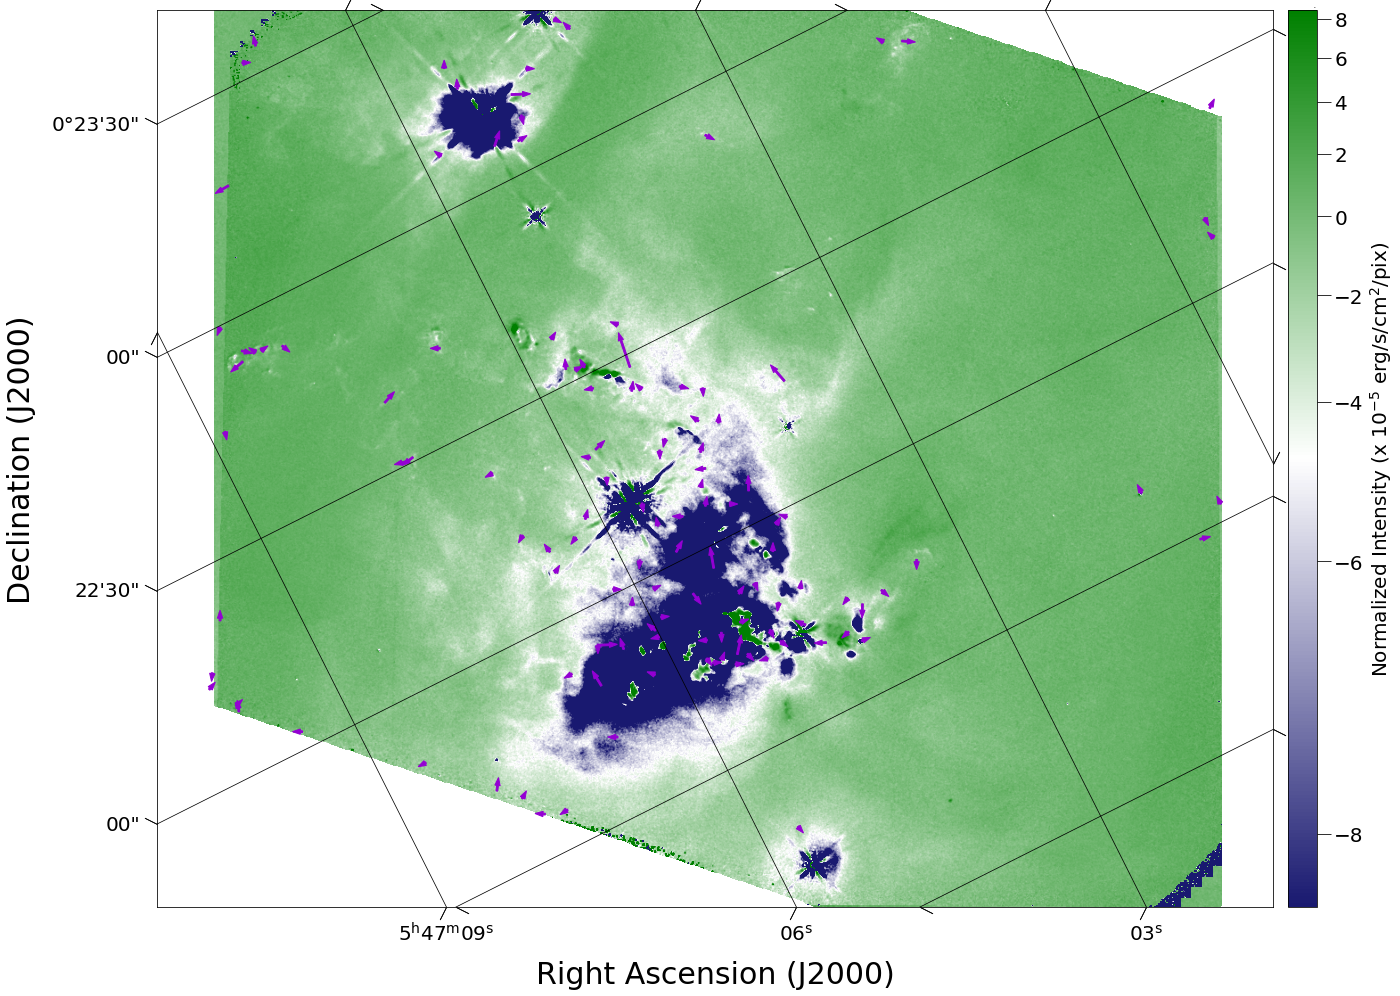

In [76]:
#overlaying on the difference image
diff_path = '../scaling_for_motions/f160_diff_epoch2_1.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
diff_hdu_list = fits.open(diff_path)
diff_data = diff_hdu_list[0].data
diff_header = diff_hdu_list[0].header

#plotting resulting image
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.visualization.stretch import SinhStretch, AsinhStretch, LogStretch
from astropy.visualization.wcsaxes import WCSAxesSubplot
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
import matplotlib.ticker
from matplotlib.ticker import LogFormatter, LogLocator, FixedLocator, FixedFormatter
                
#minor formatting for ticks
# plt.rcParams['xtick.labeltop'] = plt.rcParams['xtick.labelright'] = False
plt.rcParams['xtick.major.size'] = 14
plt.rcParams['ytick.major.size'] = 14

#plotting IRS or HOPS objects
ra_list  = ['5h47m4.785s','5h47m4.755s','5h47m4.631s','5h47m4.317s','5h47m4.623s','5h47m4.967s','5h47m5.367s','5h47m5.451s','5h47m5.125s']
dec_list = ['0d21m42.85s', '0d21m45.45s', '0d21m47.82s', '0d21m38.03s', '0d21m41.30s', '0d21m40.74s', '0d21m50.51s', '0d21m50.08s', '0d22m1.46s']
coord_sky_list = [SkyCoord(ra=i, dec=j, frame='icrs') for i,j in zip(ra_list, dec_list)]
coord_pix_list = []
for c in coord_sky_list:
    coord_pix_list.append(skycoord_to_pixel(c, WCS(hdu_header_list[0])))
    
#begin plot
fig, ax = plt.subplots(figsize=(20, 20))
#projecting to correctly present data...
wcs = WCS(hdu_header_list[0])
ax = plt.subplot(projection=wcs)


#plotting
interval = ZScaleInterval()
data_interval = interval.get_limits(diff_data)
ds9_min = -8.41819e-05
ds9_max = 8.47856e-05 
# norm = ImageNormalize(stretch=AsinhStretch(), vmin=data_interval[0], vmax=data_interval[1])
norm = ImageNormalize(stretch=AsinhStretch(), vmin=ds9_min, vmax=ds9_max)

import matplotlib.colors #to setup a new color map that is friendly to colorblindness, can also see https://www.color-blindness.com/coblis-color-blindness-simulator/
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["midnightblue","white","green"])
im = ax.imshow(hdu_data_list[0] , norm=norm, origin='lower', cmap=cmap)#'seismic')
# hops_sources = [ax.scatter(c_pair[0], c_pair[1], color='orange', marker='+', s=mark_size) for c_pair,mark_size in zip(coord_pix_list, size_list)]

#overplotting boxes and arrows to show how the method worked
from matplotlib import patches
for ind in range(len(self_brightest_list)-1):
    try:
        #boxes params    
        x_pix = center_list[ind][1]
        y_pix = center_list[ind][0]
        width_pix = shape_list[ind][1]
        height_pix = shape_list[ind][0]

        #arrow params
        x_origin = self_brightest_list[ind][0]+x_pix-width_pix/2.
        y_origin = self_brightest_list[ind][1]+y_pix-height_pix/2.
        dx = df_cc_speeds['Knot Shift in X (pix)'].values[ind]
        dy = df_cc_speeds['Knot Shift in Y (pix)'].values[ind]
        speed = df_cc_speeds['Speed (km/s)'].values[ind]
        #plotting
        
        if speed > 10.:
            ax.arrow(x_origin, y_origin, dx, dy, width=2., color='darkviolet') #use mediumorchid or darkviolet
    #         rect = patches.Rectangle((x_pix-width_pix/2., y_pix-height_pix/2.), width_pix, height_pix, linewidth=1, edgecolor='orange', facecolor='none') # Create a Rectangle patch
    #         ax.add_patch(rect) # Add the patch to the Axes
    except Exception as e:
        print(e)
        
#general formatting
ax.coords.grid(True, color='black', ls='solid', linewidth=0.75) #adding gridlines
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=30)
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=30)   
ax.tick_params(axis='x', labelbottom=True, labeltop=False, labelright=False)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.invert_yaxis() #done because it's nicer with declination increasing
ax.invert_xaxis() #done because it's nicer with declination increasing
    
#colorbar, see 3rd answer from https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax) 

#color bar label and tick labels
# sub_labels = [2]
# cbar.locator = LogLocator(base=10, subs=sub_labels)
cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm Normalized~Intensity~(x~{10}^{-5}~erg/s/{cm}^{2}/pix)$', size=20)
# cbar_tickfont = [cbar.ax.set_yticklabels(labels=cbar.ax.get_yticklabels())[i].set_fontweight('normal') for i in range(len(cbar.ax.get_yticklabels()))]

# plt.savefig('f160w_diffepoch_2_1_arrow_labeled.png', dpi=300, bbox_inches="tight")